## Training a CNN

In this lab we are going to be working with a ["17 Category Flower Dataset"](https://www.robots.ox.ac.uk/~vgg/data/flowers/17/index.html) from Visual Geometry Group of Oxford University.
We will acquire the data, split it, train multiple models and do some vizualizations. 

In [1]:
import numpy as np 
import pandas as pd 
import os 
import shutil 

### 1. Data aquisition

First, let's download the data from the webpage. You could have done it manually by going to the page, but we'll do it in the script.

In [2]:
import urllib

In [3]:
dataset_url = "https://www.robots.ox.ac.uk/~vgg/data/flowers/17/17flowers.tgz"
split_description_url = "https://www.robots.ox.ac.uk/~vgg/data/flowers/17/datasplits.mat"
#segmentation_ground_truth_url = "https://www.robots.ox.ac.uk/~vgg/data/flowers/17/trimaps.tgz"
readme_url = "https://www.robots.ox.ac.uk/~vgg/data/flowers/17/README.txt"

First, let's download the README file

In [4]:
# create folder to store data
data_folder = "data/"
os.makedirs(data_folder, exist_ok=True)

In [5]:
# let's write a function to download data as we'll use multiple times
def get_file(file_url, target_folder=""):
    filename = os.path.basename(file_url)
    # express explicitly the filepath where data will be downloaded
    target_filepath = os.path.join(target_folder, filename)
    filepath, response = urllib.request.urlretrieve(file_url, target_filepath)
    
    return filepath, response

In [6]:
# download readme file
readme_filepath, response = get_file(readme_url, data_folder)

In [7]:
# Check out the README
with open(readme_filepath, 'r') as readme:
    text = readme.read()
    print(text)

17 Flower Category Database
----------------------------------------------
This set contains images of flowers belonging to 17 different categories. 
The images were acquired by searching the web and taking pictures. There are
80 images for each category. 

The database was used in:

Nilsback, M-E. and Zisserman, A.  A Visual Vocabulary for Flower Classification.
Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (2006) 
http://www.robots.ox.ac.uk/~vgg/publications/papers/nilsback06.{pdf,ps.gz}.

The datasplits used in this paper are specified in datasplits.mat

There are 3 separate splits. The results in the paper are averaged over the 3 splits.
Each split has a training file (trn1,trn2,trn3), a validation file (val1, val2, val3)
and a testfile (tst1, tst2 or tst3). 

Segmentation Ground Truth
------------------------------------------------
The ground truth is given for a subset of the images from 13 different
categories. 

More details can be found in:

Ni

Now, let's download the data

In [8]:
# download the data
dataset_filepath, response = get_file(dataset_url, data_folder)

We have just downloaded a tar file. Let's unpack it.

In [9]:
import tarfile

In [10]:
with tarfile.open(dataset_filepath) as tar:
    tar.extractall(path=data_folder)

What have we extracted? 

In [11]:
os.listdir(data_folder)

['17flowers.tgz', 'datasplits.mat', 'jpg', 'README.txt', 'training_folder']

We see that a new folder named *jpg* has appeared.

In [12]:
os.listdir(os.path.join(data_folder, 'jpg'))[:10]

['files.txt',
 'files.txt~',
 'image_0001.jpg',
 'image_0002.jpg',
 'image_0003.jpg',
 'image_0004.jpg',
 'image_0005.jpg',
 'image_0006.jpg',
 'image_0007.jpg',
 'image_0008.jpg']

This folder contains images of the dataset. But what about ground truth?

Based on the README, each class contains exactly 80 images. Quick check shows that images of one class are grouped together. We will use this fact later to group the images by class.

The split information was already provided with the dataset (otherwise we could have used train_test_split to obtain it)

In [13]:
# download split file
split_filepath, response = get_file(split_description_url, data_folder)

In [14]:
from scipy.io import loadmat
split = loadmat(split_filepath)

In [15]:
split.keys()

dict_keys(['__header__', '__version__', '__globals__', 'trn1', 'trn2', 'trn3', 'tst1', 'tst2', 'tst3', 'val3', 'val2', 'val1'])

Let's use option 1 of train/val/test split:

In [16]:
train = split["trn1"]
val = split["val1"]
test = split["tst1"]

print("""Train set contains {} files, 
val set contains {} files, 
and test set contains {} files""".format(train.shape[1], val.shape[1], test.shape[1]))

Train set contains 680 files, 
val set contains 340 files, 
and test set contains 340 files


### Excercise
Additional things to do:
- Check how many images we have downloaded.

In [17]:
assert(17*80==len(train[0]) + len(val[0]) + len(test[0]))
print(f"We have {17*80} images")

We have 1360 images


- Display some of the images.

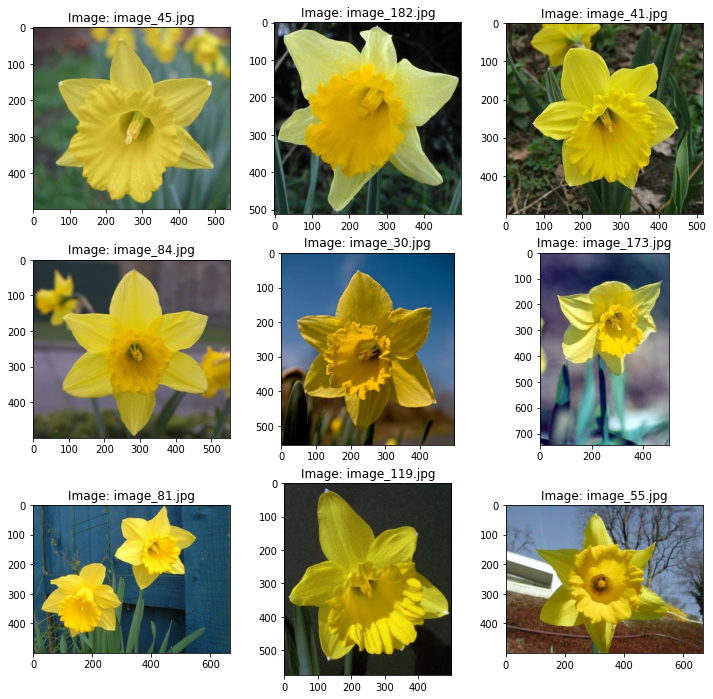

In [18]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
img = mpimg.imread(os.path.join(data_folder,f'jpg/image_00{train[0][42]}.jpg'),)

path = os.path.join(data_folder,'jpg/image_00')

indices = np.random.randint(0,200,size=9)
fig,axes = plt.subplots(3,3,figsize=(12,12))
for ind, ax in enumerate(axes.flat):
    index = train[0][ind]
    if index<10:
        imagepath = path+'0'+str(index)+'.jpg'
    else:
        imagepath = path + str(index)+'.jpg'
    img = mpimg.imread(imagepath)
    ax.imshow(img)
    ax.set_title(f"Image: image_{indices[ind]}.jpg")

- Are those color images? 

-YES

- What are their shape? 

In [19]:
img.shape #example shape

(500, 666, 3)

- Are they all of the same shape?

In [20]:
img2 = mpimg.imread(path+'47.jpg')
img2.shape

(760, 500, 3)

-NO, the shapes are different

### 2. Data regrouping

During the training with Keras for the simplicity we are going to be using flow_from_dir method of ImageDataGenerator. However, we'll need to organize data first in the specific manner: separate train, val, test sets, and put images of each class in a designated folder. 


First, let's write a function to get a class name from file index. We'll use the fact that each class has 80 images, and they are grouped together by index. 

In [21]:
def get_image_class(file_index):
    image_class_idx = (int(file_index) - 1) // 80 + 1
    class_name = "{:02d}".format(image_class_idx)
    
    return class_name

Now let's rearrange the data

In [22]:
from shutil import copy

In [23]:
training_folder_name = "training_folder"

In [24]:
for filename in os.listdir(os.path.join(data_folder, 'jpg')):
    if filename.endswith('jpg'):
        ### filename 'image_0936.jpg' --> file_index 936
        file_index = int(filename[6:10])
        true_class = get_image_class(file_index)
        if file_index in train:
            split_folder = 'train'
        elif file_index in val:
            split_folder = 'val'
        elif file_index in test:
            split_folder = 'test'     
        
        target_folder = os.path.join(data_folder, training_folder_name, split_folder, true_class)
        os.makedirs(target_folder, exist_ok=True)
        
        source_filepath = os.path.join(data_folder, 'jpg', filename)
        copy(source_filepath, target_folder)
    else:
        print(filename)
        print("Not a jpg file, skipping")
    

files.txt
Not a jpg file, skipping
files.txt~
Not a jpg file, skipping


### 3. CNN training

Now that we have prepared the data, we will be able to train a model.

#### 3.1 Transfer learning

Let's do the [transfer learning](https://papers.nips.cc/paper/5347-how-transferable-are-features-in-deep-neural-networks.pdf) we have briefly discussed last time. We'll load one of the pretrained models from Keras library with [ImageNet weights](http://www.image-net.org/).

##### Model preparation

In [25]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K


import os

c:\users\eddie\kma_course\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\eddie\kma_course\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\eddie\kma_course\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\eddie\kma_course\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: P

In [26]:
# Reproducibility!
np.random.seed(42)
tf.set_random_seed(42)

In [27]:
# # """## GPU selection --> execute do only if you need to select a GPU / part of GPU

# os.environ["CUDA_VISIBLE_DEVICES"] = "0" 

# ### Set session with share of GPU
# config_1 = tf.ConfigProto()
# # gpu_fraction_1 = float(os.environ.get('GPU_LIMIT_1', 0.45))
# # config_1.gpu_options.per_process_gpu_memory_fraction = gpu_fraction_1
# config_1.gpu_options.allow_growth = True

# sess_1 = tf.Session(config=config_1)
# sess_1.run(tf.global_variables_initializer())
# K.set_session(sess_1)

We'll be using VGG16 model. Together with weights, we'll also need a corresponding preprocessing function for the input images.

In [28]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_input_vgg

from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model

In [29]:
base_model = VGG16(include_top=False, weights='imagenet', input_shape = (224,224,3))
base_model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________

Note that we have downloaded only a convolution part of the neural network. Let's add some dense layers on top of it.

In [30]:
## freezing the layers

#for layer in base_model.layers:
#    layer.trainable = False

In [31]:
nb_classes = 17

In [32]:
flatten = Flatten()(base_model.output)
dropout_1 = Dropout(0.25)(flatten)
fc_1 = Dense(1000)(dropout_1)
dropout_2 = Dropout(0.5)(fc_1)
predictions = Dense(nb_classes, activation="softmax", name='predictions')(dropout_2)

In [33]:
model = Model(base_model.input, predictions)

In [34]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

##### Model training parameters

In [35]:
from tensorflow.keras import optimizers

In [36]:
loss = 'categorical_crossentropy'
learning_rate = 0.001
optimizer = optimizers.SGD ## optimizers.SGD ## optimizers.RMSprop ## optimizers.Adagrad ## optimizers.Adadelta
metrics = ['accuracy']

In [37]:
model.compile(loss=loss,
              optimizer=optimizer(learning_rate),
              metrics=metrics)

##### Data preparation

In [38]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [39]:
train_dir = os.path.join(data_folder, training_folder_name, "train")
val_dir = os.path.join(data_folder, training_folder_name, "val")
test_dir = os.path.join(data_folder, training_folder_name, "test")

In [40]:
# we'll resize images in correspondance to network input size
image_size = (224,224)

In [41]:
# apply some data augmentation
train_datagen = ImageDataGenerator(rotation_range=15,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                   preprocessing_function=preprocess_input_vgg
                                  )

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_vgg) # for validation we don't need to augment

train_batchsize = 30
val_batchsize = 30

# this function takes images from folders and feeds to Imagedatagenerator
train_generator = train_datagen.flow_from_directory( 
        train_dir,
        target_size=image_size,
        batch_size=train_batchsize,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        val_dir,
        target_size=image_size,
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 680 images belonging to 17 classes.
Found 340 images belonging to 17 classes.


##### Model training

In [42]:
epochs = 50

In [43]:
nb_train_steps = train_generator.samples // train_generator.batch_size
nb_val_steps = validation_generator.samples // validation_generator.batch_size

In [44]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=nb_train_steps,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps=nb_val_steps,
      verbose=1, #0
)

Epoch 1/50
22/22 [==============================] - 33s 2s/step - loss: 5.1333 - acc: 0.0523 - val_loss: 2.8307 - val_acc: 0.0758
Epoch 2/50
22/22 [==============================] - 22s 1s/step - loss: 2.8348 - acc: 0.0723 - val_loss: 2.8277 - val_acc: 0.0727
Epoch 3/50
22/22 [==============================] - 22s 1s/step - loss: 2.8360 - acc: 0.0600 - val_loss: 2.8265 - val_acc: 0.0424
Epoch 4/50
22/22 [==============================] - 22s 1s/step - loss: 2.8332 - acc: 0.0462 - val_loss: 2.8196 - val_acc: 0.0788
Epoch 5/50
22/22 [==============================] - 22s 1s/step - loss: 2.8287 - acc: 0.0585 - val_loss: 2.8187 - val_acc: 0.1000
Epoch 6/50
22/22 [==============================] - 22s 1s/step - loss: 2.8298 - acc: 0.0600 - val_loss: 2.8157 - val_acc: 0.0818
Epoch 7/50
22/22 [==============================] - 22s 1s/step - loss: 2.8261 - acc: 0.0892 - val_loss: 2.8214 - val_acc: 0.0697
Epoch 8/50
22/22 [==============================] - 22s 1s/step - loss: 2.8184 - acc: 0.09

In [45]:
print('training acc.:',history.history['acc'][-1])
print('val acc.:', (history.history['val_acc'])[-1])

training acc.: 0.7630769
val acc.: 0.7818182


In [46]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy %')
    plt.plot(history.epoch, np.array(history.history['acc']),
    label='Train Accuracy')
    plt.plot(history.epoch, np.array(history.history['val_acc']),
    label = 'Val Accuracy')
    plt.legend()
    plt.ylim([0, 1])

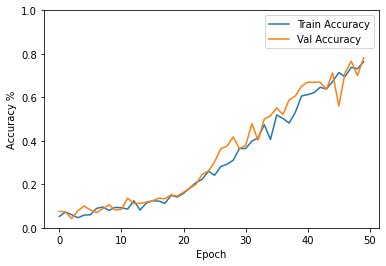

In [47]:
plot_history(history)

##### Save model

In [48]:
weights_folder = "weights"
os.makedirs(weights_folder, exist_ok=True)

model_name = 'vgg16_transfer_weights.h5'
model_path = os.path.join(weights_folder, model_name)

In [49]:
# uncomment to save model
# model.save(model_path)

##### Do the test on images

In [50]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

In [51]:
# model = load_model(model_path, compile=False)

###### Single image prediction

In [52]:
#test_dir = "data/training_folder/test"
#image_size = (224,224)

In [53]:
class_idx = '08'
image_name = os.listdir(os.path.join(test_dir, class_idx))[0]
image_path = os.path.join(test_dir, class_idx, image_name)

In [54]:
image_path

'data/training_folder\\test\\08\\image_0564.jpg'

In [55]:
# predicting image: getting the output vector
img = image.load_img(image_path, target_size=image_size)
img_array = image.img_to_array(img)
img_expanded = np.expand_dims(img_array, axis=0)
preprocessed_image = preprocess_input_vgg(img_expanded)

pred = model.predict(preprocessed_image)
print(pred)

[[2.5455248e-01 1.2235704e-06 4.3765303e-07 2.1682472e-05 1.9703209e-06
  9.0924817e-07 1.5998894e-05 7.3553097e-01 2.3544788e-05 3.9512652e-04
  1.7409110e-06 3.0837407e-05 1.4433003e-04 2.6464569e-03 6.3373023e-03
  4.6452965e-07 2.9449983e-04]]


In [56]:
img_expanded.shape

(1, 224, 224, 3)

In [57]:
img_array.shape

(224, 224, 3)

In [58]:
classes = ["{:02d}".format(i) for i in range(1, 18)]
pred_class_idx = np.argmax(pred, axis=1)
classes[pred_class_idx[0]]

'08'

In [59]:
pred[0][pred_class_idx]

array([0.735531], dtype=float32)

###### Multiple image predictions

In [60]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns; sns.set()

In [61]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_vgg) 

In [62]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=image_size,
        shuffle = False,
        class_mode='categorical',
        batch_size=1)

filenames = test_generator.filenames
nb_samples = len(filenames)

predict = model.predict_generator(test_generator,steps=nb_samples)

Found 340 images belonging to 17 classes.


In [63]:
predict.shape

(340, 17)

Confusion Matrix


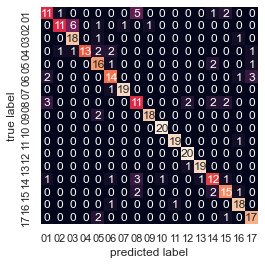

In [64]:
y_pred = np.argmax(predict, axis=1)
print('Confusion Matrix')

mat = confusion_matrix(test_generator.classes, y_pred)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel('predicted label')
plt.ylabel('true label');

In [65]:
#my results - lesser batch size
#results heavily depend on seed - acc varies in range 0.2 - 0.9
print(classification_report(test_generator.classes + 1, y_pred + 1))  ## adding 1 to preserve the class naming

              precision    recall  f1-score   support

           1       0.65      0.55      0.59        20
           2       0.85      0.55      0.67        20
           3       0.72      0.90      0.80        20
           4       1.00      0.65      0.79        20
           5       0.67      0.80      0.73        20
           6       0.70      0.70      0.70        20
           7       0.95      0.95      0.95        20
           8       0.52      0.55      0.54        20
           9       0.95      0.90      0.92        20
          10       0.95      1.00      0.98        20
          11       0.95      0.95      0.95        20
          12       0.87      1.00      0.93        20
          13       0.95      0.95      0.95        20
          14       0.63      0.60      0.62        20
          15       0.71      0.75      0.73        20
          16       0.82      0.90      0.86        20
          17       0.77      0.85      0.81        20

    accuracy              

In [66]:
##original results
print(classification_report(test_generator.classes + 1, y_pred + 1))  ## adding 1 to preserve the class naming

              precision    recall  f1-score   support

           1       0.65      0.55      0.59        20
           2       0.85      0.55      0.67        20
           3       0.72      0.90      0.80        20
           4       1.00      0.65      0.79        20
           5       0.67      0.80      0.73        20
           6       0.70      0.70      0.70        20
           7       0.95      0.95      0.95        20
           8       0.52      0.55      0.54        20
           9       0.95      0.90      0.92        20
          10       0.95      1.00      0.98        20
          11       0.95      0.95      0.95        20
          12       0.87      1.00      0.93        20
          13       0.95      0.95      0.95        20
          14       0.63      0.60      0.62        20
          15       0.71      0.75      0.73        20
          16       0.82      0.90      0.86        20
          17       0.77      0.85      0.81        20

    accuracy              

Things to do

- Check some of incorrectly classified images
- Experiment with other models available in Keras
- Build your own network
- Optimize one or several training hyperparameters

#### 3.2 Training enhancement

There are multiple ways to improve the quality of the model. Have a look at these papers that provide some heuristics for training a [classification](https://arxiv.org/pdf/1812.01187.pdf) or [object detection](https://arxiv.org/pdf/1902.04103.pdf) model.

I've done the following:
* used resnet50 with smaller images
* added custom LR Scheduler and EarlyStopping

In [67]:
from tensorflow.keras.applications.resnet50 import ResNet50 
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [68]:
base_model = ResNet50(include_top=False, weights='imagenet', input_shape = (112,112,3))
# base_model.summary()

#Note that we have downloaded only a convolution part of the neural network. Let's add some dense layers on top of it.

nb_classes = 17

flatten = Flatten()(base_model.output)
dropout_1 = Dropout(0.25)(flatten)
fc_1 = Dense(1000)(dropout_1)
dropout_2 = Dropout(0.5)(fc_1)
predictions = Dense(nb_classes, activation="softmax", name='predictions')(dropout_2)

model = Model(base_model.input, predictions)

# model.summary()

c:\users\eddie\kma_course\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [69]:
# we'll resize images in correspondance to network input size
image_size = (112,112)

In [70]:
# apply some data augmentation
train_datagen = ImageDataGenerator(rotation_range=15,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                   preprocessing_function=preprocess_input_vgg
                                  )

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_vgg) # for validation we don't need to augment

train_batchsize = 30
val_batchsize = 30

# this function takes images from folders and feeds to Imagedatagenerator
train_generator = train_datagen.flow_from_directory( 
        train_dir,
        target_size=image_size,
        batch_size=train_batchsize,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        val_dir,
        target_size=image_size,
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 680 images belonging to 17 classes.
Found 340 images belonging to 17 classes.


##### Model training parameters

In [74]:
loss = 'categorical_crossentropy'
learning_rate = 0.001
optimizer = optimizers.SGD ## optimizers.SGD ## optimizers.RMSprop ## optimizers.Adagrad ## optimizers.Adadelta
metrics = ['accuracy']
epochs = 50
model.compile(loss=loss,
              optimizer=optimizer(learning_rate),
              metrics=metrics)

In [72]:
nb_train_steps = train_generator.samples // train_generator.batch_size
nb_val_steps = validation_generator.samples // validation_generator.batch_size

In [73]:
def step_decay(epoch,lr):
    decay_rate = 0.9
    decay_step = 10
    if epoch% decay_step ==0 and epoch:
        return lr * decay_rate
    return lr

In [75]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=nb_train_steps,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps=nb_val_steps,
      verbose=1, #0
      callbacks=[tf.keras.callbacks.EarlyStopping(patience=5,monitor='loss',restore_best_weights=True), tf.keras.callbacks.LearningRateScheduler(step_decay,verbose=1)]
)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 1/50
22/22 [==============================] - 15s 691ms/step - loss: 5.6794 - acc: 0.2000 - val_loss: 2.5075 - val_acc: 0.4909

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 2/50
22/22 [==============================] - 7s 313ms/step - loss: 2.7803 - acc: 0.4600 - val_loss: 2.3152 - val_acc: 0.6273

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 3/50
22/22 [==============================] - 7s 310ms/step - loss: 1.8465 - acc: 0.6154 - val_loss: 1.4151 - val_acc: 0.7212

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 4/50
22/22 [==============================] - 7s 306ms/step - loss: 1.3209 - acc: 0.7123 - val_loss: 1.1988 - val_acc: 0.7576

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 5/50
22/22 [============================

In [76]:
print('training acc.:',history.history['acc'][-1])
print('val acc.:', (history.history['val_acc'])[-1])

training acc.: 0.9692308
val acc.: 0.8969697


In [77]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy %')
    plt.plot(history.epoch, np.array(history.history['acc']),
    label='Train Accuracy')
    plt.plot(history.epoch, np.array(history.history['val_acc']),
    label = 'Val Accuracy')
    plt.legend()
    plt.ylim([0, 1])

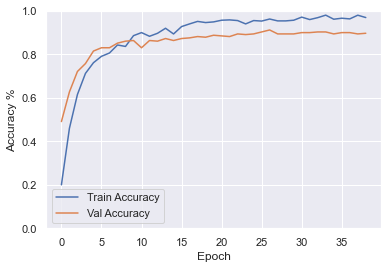

In [78]:
plot_history(history)

##### 3.2.1 Data augmentation

Better data augmentation can easily give a boost to a model. Some of the useful tools include
- [imgaug](https://github.com/aleju/imgaug)
- [mixup](https://arxiv.org/pdf/1710.09412.pdf)

In [76]:
!pip install imgaug

In [ ]:
from imgaug import augmenters as iaa

seq = iaa.Sequential([
    iaa.Crop(px=(0,32)),
    iaa.Friplr(0.5),
    iaa.GaussianBlur(sigma=(0,4.4))
])
base_model = ResNet50(include_top=False, weights='imagenet', input_shape = (112,112,3))
model = Model(base_model.input, predictions)


##### 3.2.2 Learning rate scheduling and early stopping criteria

In Keras learning rate scheduling and early stopping criteria can be implemented using [Callbacks](https://keras.io/callbacks/). In particular, the following are quite useful: LearningRateScheduler, ReduceLROnPlateau, EarlyStopping,  CSVLogger, ModelCheckpoint.